In [154]:
# Import data 

import os

def pcap2csv(pcap, csv):
    
    if os.path.isfile(csv):
        print ("CSV file exist. Deleting old CSV...")
        os.remove(csv)
    else:
        pass
        
    if not os.path.isfile(pcap):
        print ("PCAP file not exist. Plaese, check filename.")
    else:
        pass

    os.system("""
tshark -o tcp.desegment_tcp_streams:false -r {input} -n -T fields -E header="y" -E separator="," -e ip.src -e ip.dst -e ip.len -e ip.proto -e ip.flags.df -e ip.flags.mf -e ip.frag_offset -e ip.id -e ip.ttl -e udp.srcport -e udp.dstport -e tcp.srcport -e tcp.dstport -e tcp.flags.syn -e tcp.flags.ack -e tcp.flags.fin -e tcp.flags.reset -e tcp.flags.push -e tcp.flags.urg -e tcp.flags.ecn -e tcp.flags.cwr -e tcp.seq_raw -e tcp.ack_raw -e icmp.type -e icmp.code -e data.data > {output}
    """.format(input=pcap, output=csv))
    
    if os.path.isfile(csv):
        print ("CSV {name} created.".format(name=csv))
    else:
        return -1

pcap2csv("DayZ_attack.pcap", "DayZ_attack.csv")
pcap2csv("DayZ_legit.pcap", "DayZ_legit.csv")

pcap2csv("Minecraft_attack.pcap", "Minecraft_attack.csv")
pcap2csv("Minecraft_legit.pcap", "Minecraft_legit.csv")

CSV file exist. Deleting old CSV...
CSV DayZ_attack.csv created.
CSV file exist. Deleting old CSV...
CSV DayZ_legit.csv created.
CSV file exist. Deleting old CSV...
CSV Minecraft_attack.csv created.
CSV file exist. Deleting old CSV...
CSV Minecraft_legit.csv created.


In [155]:
import numpy as np
import pandas as pd
import socket, struct

def combine(*columns):
    global df
    head, *tail = columns
    result = df[head]
    for column in tail:
        result = result.fillna(df[column])
    result = result.fillna(0)
    df.drop(list(columns), axis=1, inplace=True)
    return result.fillna(0)

def for_columns(prefix, action):
    global df
    columns = filter(lambda name: name.startswith(prefix), df.columns)
    for column in columns:
        df[column] = action(df[column])

def fillna_all(prefix, value=0):
    global df
    columns = filter(lambda name: name.startswith(prefix), df.columns)
    for column in columns:
        df[column].fillna(value, inplace=True)

def ip_to_int(ip):
    return struct.unpack('>I', socket.inet_aton(ip))[0]

def df_prep(acsv, lcsv):
    adf = pd.read_csv(acsv) #'attack.csv')
    adf["attack"] = 1

    ldf = pd.read_csv(lcsv)
    ldf["attack"] = 0
    
    global df
    df = pd.concat([adf, ldf], ignore_index=True)

    # Fill N/A

    df["ip.src"] = df["ip.src"].apply(ip_to_int)
    df["ip.dst"] = df["ip.dst"].apply(ip_to_int)
    df["ip.id"] = df["ip.id"].apply(lambda x: int(x, 16))

    fillna_all("tcp.")
    fillna_all("icmp.")

    # Generate derivative fields

    df["has_icmp"] = df["ip.proto"] == socket.IPPROTO_ICMP
    df["has_tcp"] = df["ip.proto"] == socket.IPPROTO_TCP
    df["has_port"] = df["has_tcp"] | (df["ip.proto"] == socket.IPPROTO_UDP)

    df["srcport"] = combine("udp.srcport", "tcp.srcport").astype(np.int64)
    df["dstport"] = combine("udp.dstport", "tcp.dstport").astype(np.int64)

    # Fix data types

    df["ip.ttl"] = df["ip.ttl"].astype(np.int64)
    for_columns("ip.flags.", lambda column: column.astype(np.bool))

    for_columns("tcp.flags.", lambda column: column.astype(np.bool))
    df["tcp.seq_raw"] = df["tcp.seq_raw"].astype(np.int64)
    df["tcp.ack_raw"] = df["tcp.ack_raw"].astype(np.int64)

    for_columns("icmp.", lambda column: column.astype(np.int64))
    
    global names
    
    names = df.columns
    
    return df

false_alarm_df = df_prep("DayZ_legit.csv", "DayZ_legit.csv")
dayz_df = df_prep("DayZ_attack.csv", "DayZ_legit.csv")
minecraft_df = df_prep("Minecraft_attack.csv", "Minecraft_legit.csv")

In [156]:
# Equal distribution of data

from sklearn.model_selection import StratifiedShuffleSplit

def StratDataSplit(df):
    split_df = StratifiedShuffleSplit(n_splits=1, test_size=0.2,
                                     random_state = 42)
    for train_index, test_index in split_df.split(df, df["attack"]):
        strat_train_set = df.loc[train_index]
        strat_test_set = df.loc[test_index]
    return(strat_train_set, strat_test_set)
        
false_alarm_train_set, false_alarm_test_set = StratDataSplit(false_alarm_df)
dayz_train_set, dayz_test_set = StratDataSplit(dayz_df)
minecraft_train_set, minecraft_test_set = StratDataSplit(minecraft_df)

In [157]:
# Train data preparation

from sklearn.impute import SimpleImputer

def NumCatPrep(start_train_set, start_test_set):
    train = start_train_set.copy()
    test = start_test_set.copy()

    train_data = train.drop(labels=["attack", "data.data"], axis=1).values
    train_target = train["attack"]

    test_data = test.drop(labels=["attack", "data.data"], axis=1).values
    test_target = test["attack"]
    
    return(train_data, test_data, train_target, test_target)
    
false_alarm_train_data, false_alarm_test_data, false_alarm_train_target, false_alarm_test_target = NumCatPrep(
false_alarm_train_set, false_alarm_test_set)

dayz_train_data, dayz_test_data, dayz_train_target, dayz_test_target = NumCatPrep(
dayz_train_set, dayz_test_set)

minecraft_train_data, minecraft_test_data, minecraft_train_target, minecraft_test_target = NumCatPrep(
minecraft_train_set, minecraft_test_set)

In [158]:
# Decision tree train and test

from sklearn import tree
from sklearn.metrics import accuracy_score

def TrainFoo(train_data, train_target):    
    traffic_clf = tree.DecisionTreeClassifier(max_depth = 5,
        min_samples_leaf = 0.01)
    return (traffic_clf.fit(train_data, train_target))

def TestFoo(estimator ,test_data, test_target, label):    
    test_predict = estimator.predict(test_data)
    print("Accuracy in the case of {name} is {p}".format(
        p = accuracy_score(test_target, test_predict),
        name = label))
    
false_alarm_clf = TrainFoo(false_alarm_train_data, false_alarm_train_target)
TestFoo(false_alarm_clf, false_alarm_test_data, false_alarm_test_target, "false alarm")

dayz_clf = TrainFoo(dayz_train_data, dayz_train_target)
TestFoo(dayz_clf, dayz_test_data, dayz_test_target, "DayZ")

minecraft_clf = TrainFoo(minecraft_train_data, minecraft_train_target)
TestFoo(minecraft_clf, minecraft_test_data, minecraft_test_target, "Minecraft")

Accuracy in the case of false alarm is 0.486625
Accuracy in the case of DayZ is 0.9988181818181818
Accuracy in the case of Minecraft is 1.0


In [159]:
# Tree illustration

import matplotlib as mpl

def TreeIllustrator(estimator, data):
    mpl.rcParams['figure.dpi'] = 1024

    _ = tree.plot_tree(estimator,
                       feature_names=data,
                       filled=True,
    #                  proportion=True,
                      )

Ниже изображены деревья для всех трех случаев. 

В каждом узле присутствует: правило фильтрации, индекс Джини, количество образцов траффика в данном узле и количество образцов каждого типа в квадратных скобках.

Индекс Джини является "мерой загрязнености" -- чем он ближе стремится к 0 в каждом случае, тем чище отфильтрован трафик.

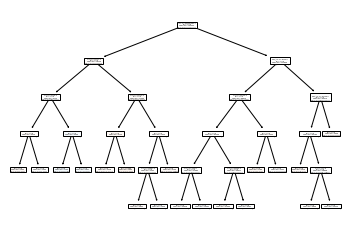

In [160]:
TreeIllustrator(false_alarm_clf, names)

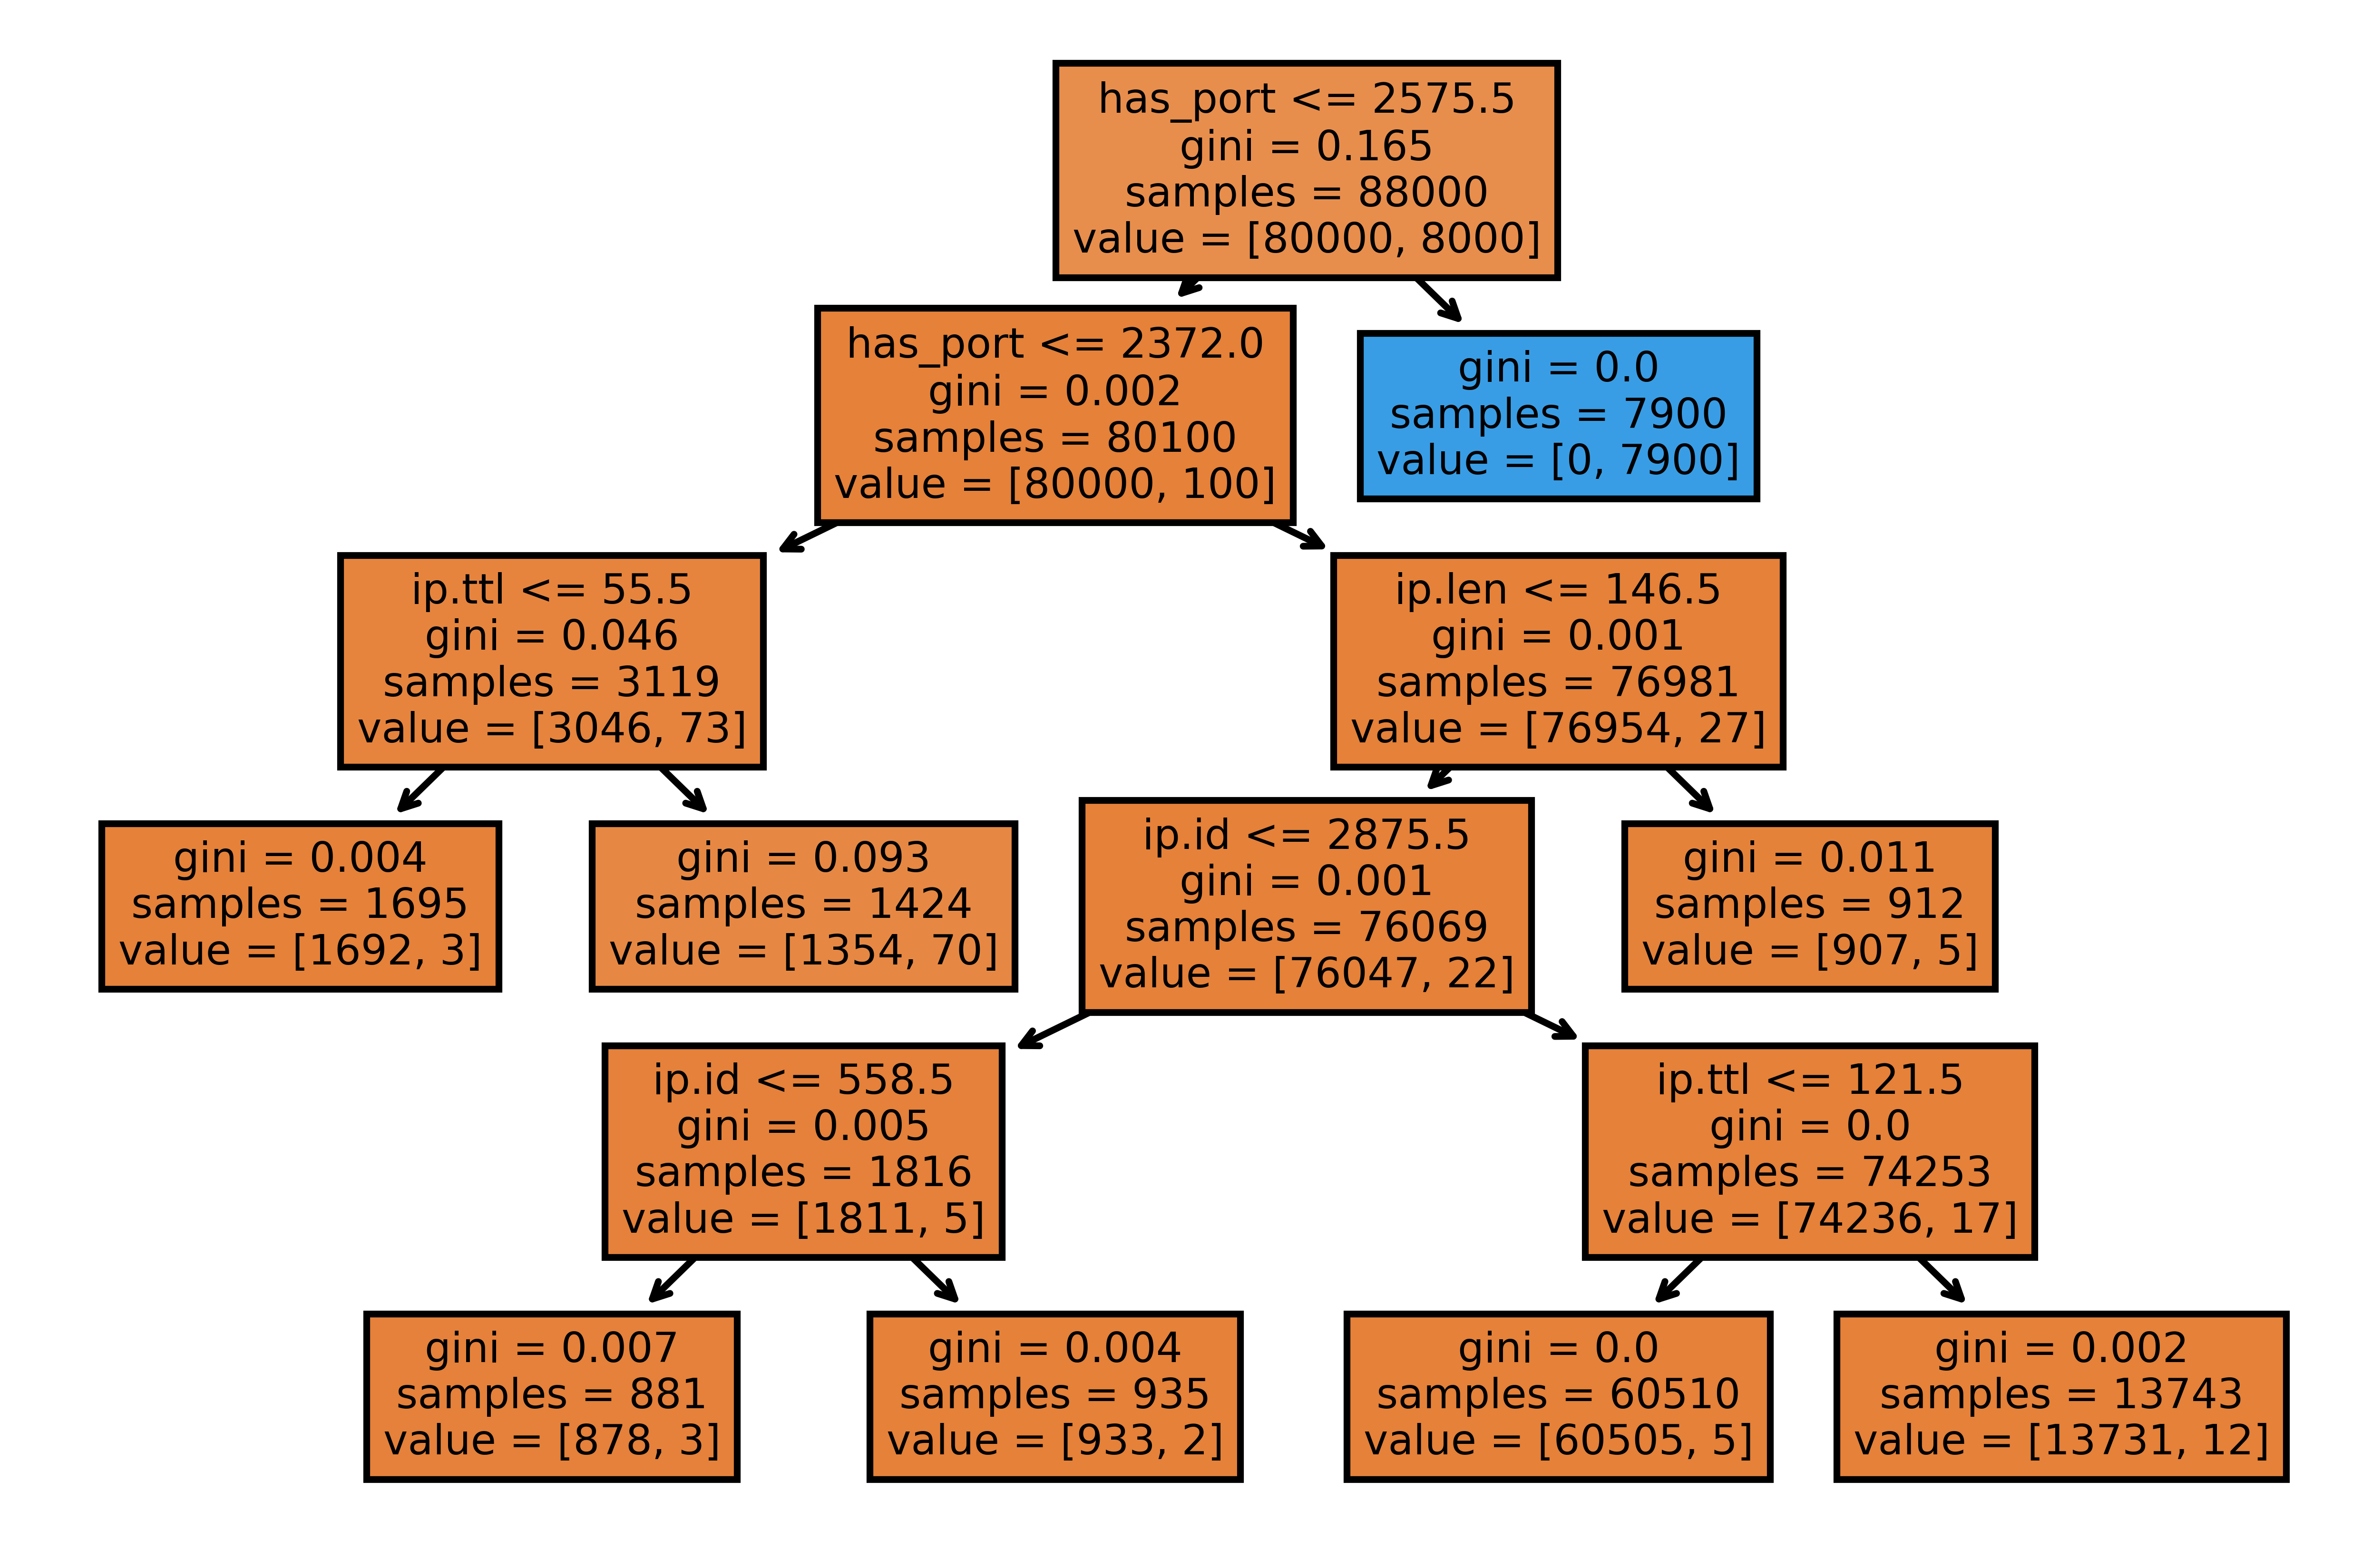

In [161]:
TreeIllustrator(dayz_clf, names)

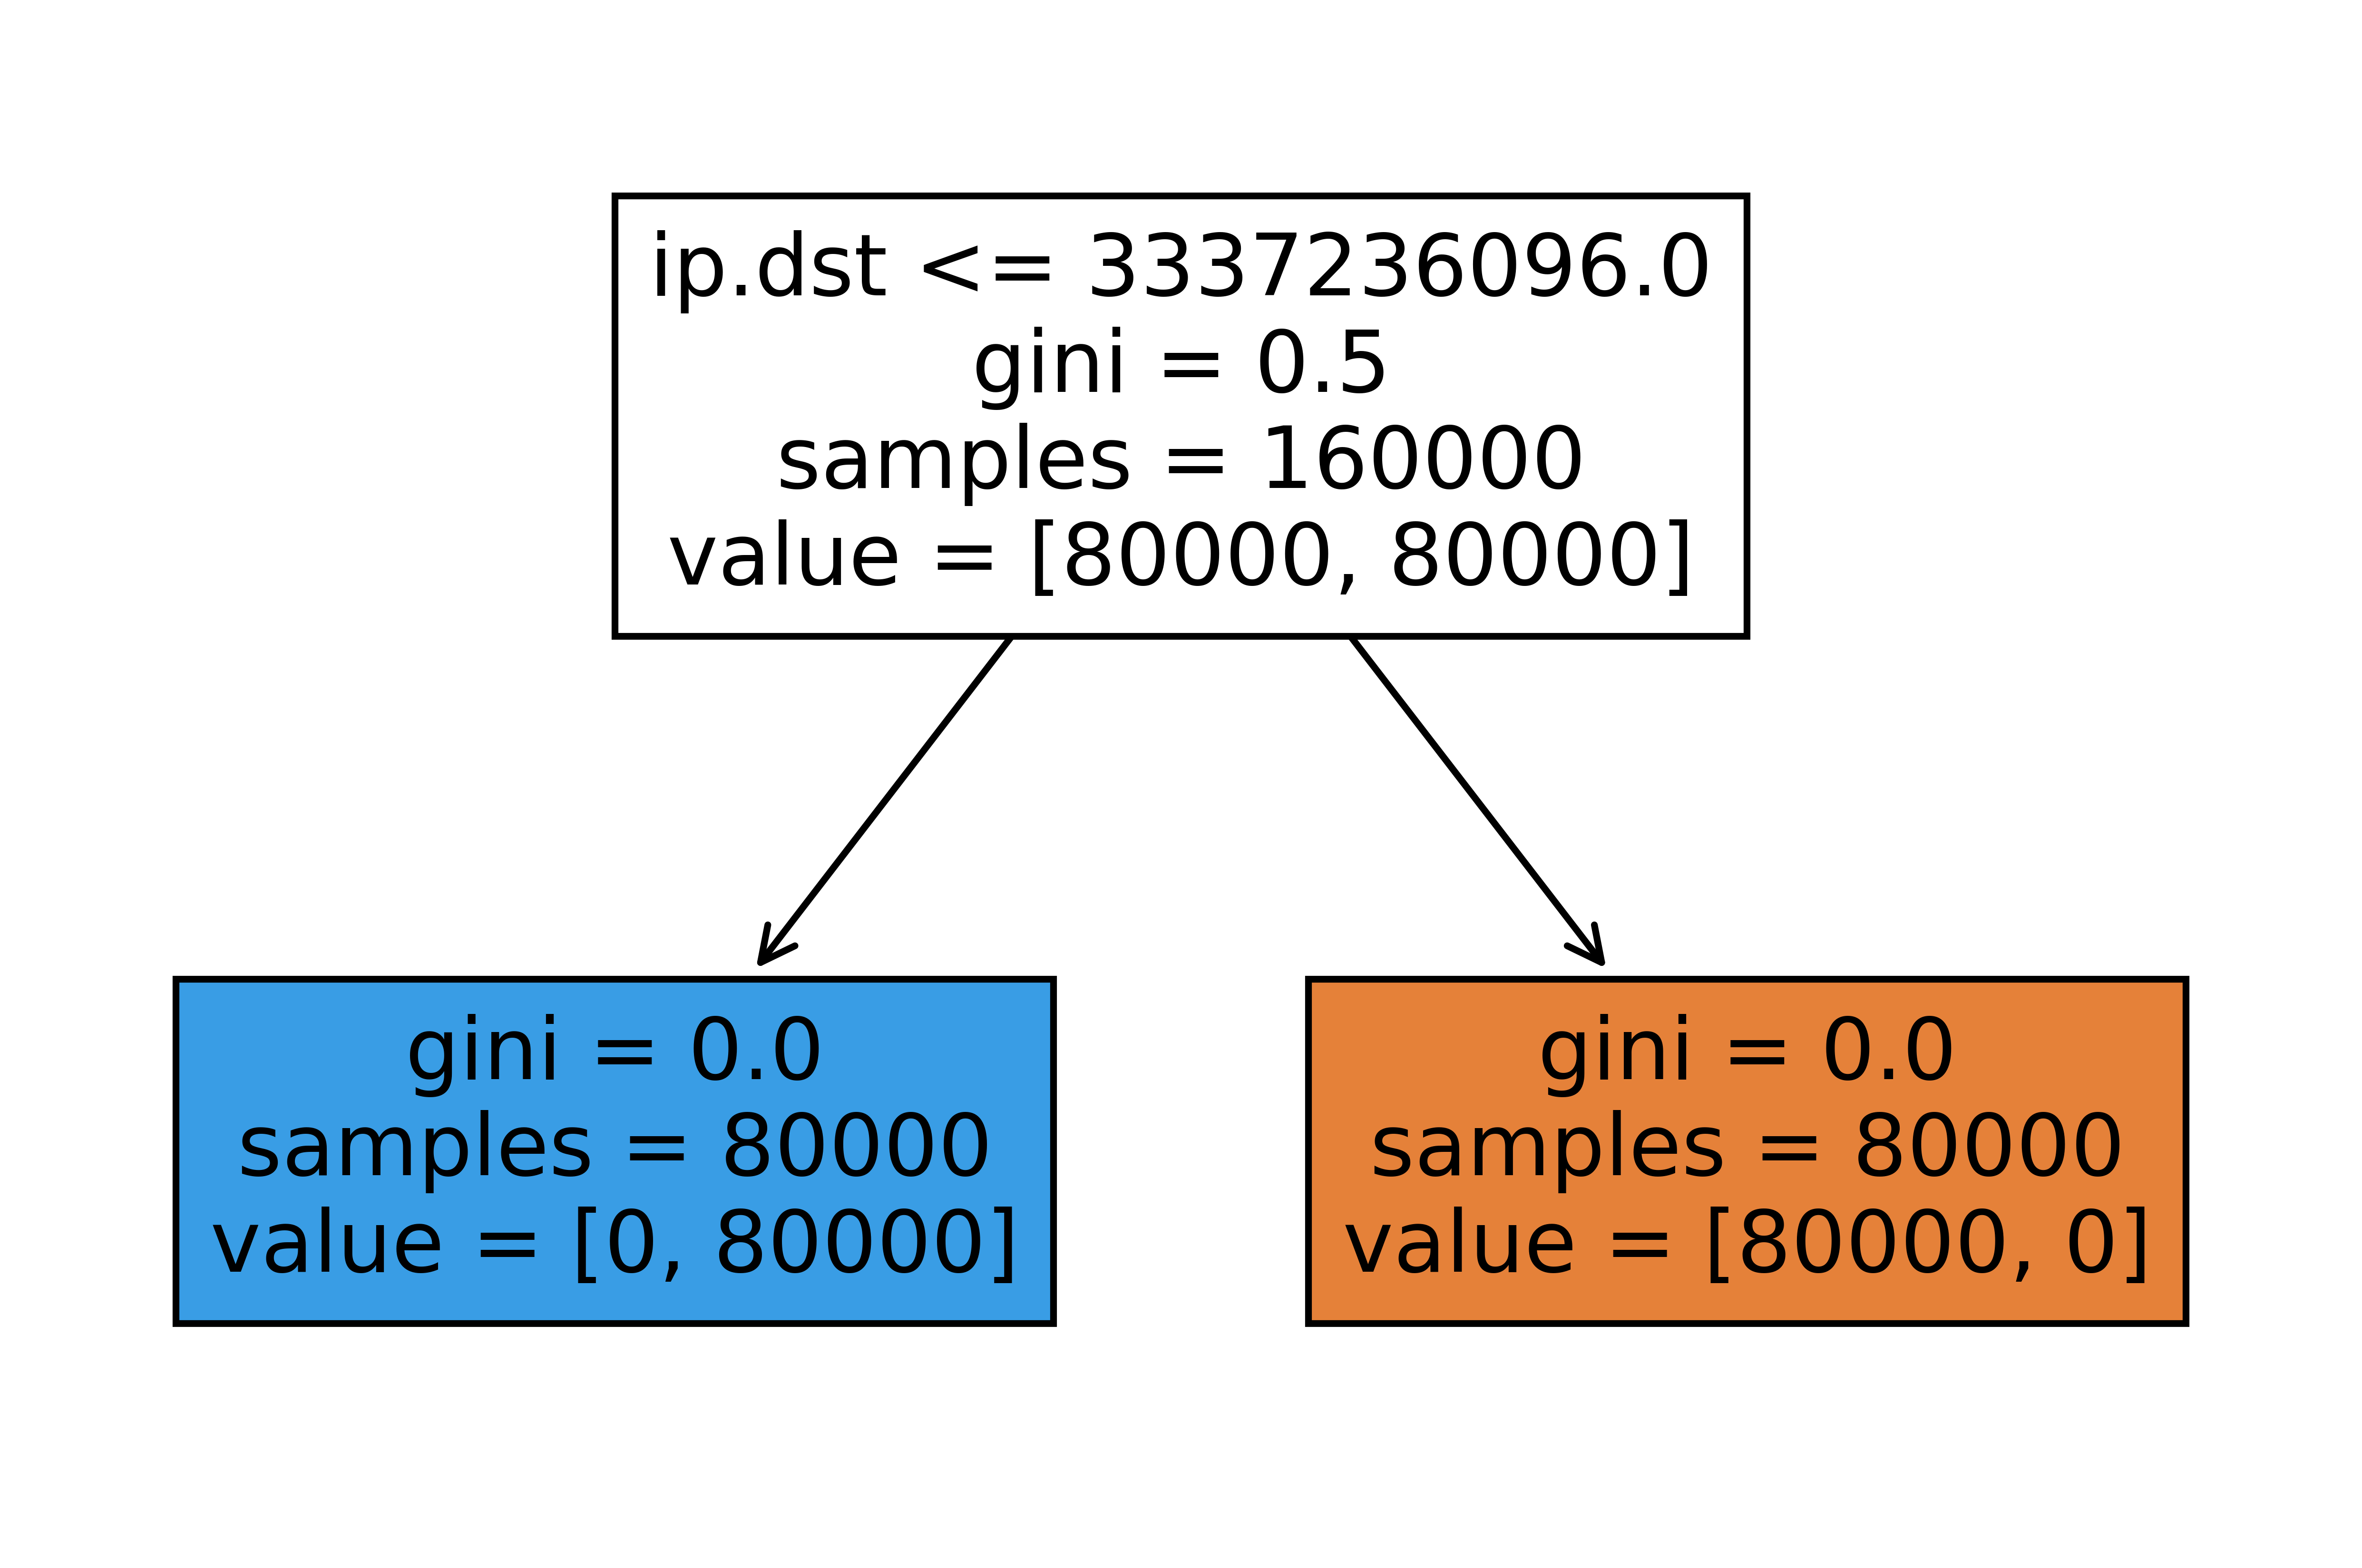

In [162]:
TreeIllustrator(minecraft_clf, names)